# Comparison of MEFISTO and PRISMO on Visium Data from MEFISTO paper

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import scanpy as sc
import matplotlib.pyplot as plt
import umap
import pandas as pd
import seaborn as sns
import numpy as np

from data_loader import load_mefisto_visium

from famo.core import CORE, DataOptions, ModelOptions, TrainingOptions, SmoothOptions
from famo.utils_gpu import get_free_gpu_idx
from famo.utils_io import load_model
from famo.utils_downstream import match
from famo.plotting import plot_training_curve, plot_variance_explained, plot_factor_correlation, plot_factors_scatter

/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [3]:
adata = load_mefisto_visium()
adata.var_names = adata.var_names.str.upper()
adata

/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:275: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
/home/aqoku/projects/code/prismo-analysis/comparison_mefisto_visium/data_loader.py:31: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.


AnnData object with n_obs × n_vars = 2487 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg'
    obsm: 'spatial'

<Axes: >

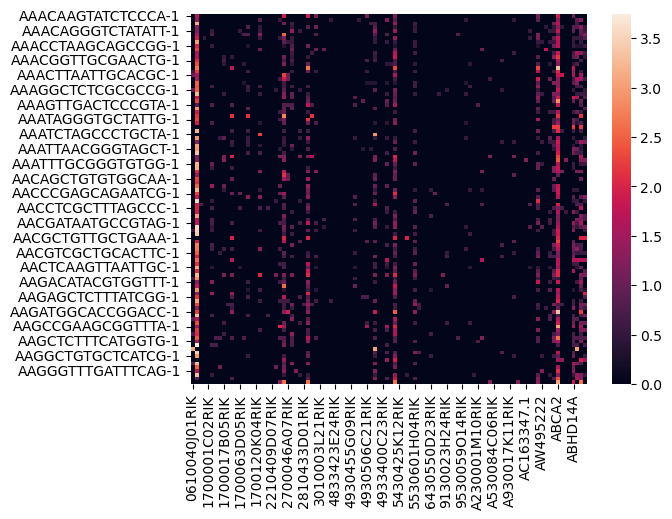

In [4]:
sns.heatmap(adata.to_df().iloc[:100, :100])

In [5]:
feature_stds = adata.to_df().std()
(feature_stds > 0).mean()

1.0

In [6]:
from famo import feature_sets

In [7]:
def to_upper(feature_set_collection):
    return feature_sets.FeatureSets(
        [
            feature_sets.FeatureSet([f.upper() for f in fs], fs.name)
            for fs in feature_set_collection
        ],
        name=feature_set_collection.name,
    )

In [8]:
hallmark_collection = feature_sets.from_gmt(
    "../msigdb/mh.all.v2024.1.Mm.symbols.gmt", name="hallmark"
)


panglao_df = pd.read_csv("../msigdb/PanglaoDB_markers_27_Mar_2020.tsv", sep="\t")
panglao_df = panglao_df.loc[panglao_df["species"].isin(["Mm Hs", "Mm"]) & (panglao_df["organ"] == "Brain"), :].copy()

celltype_collection = feature_sets.from_dataframe(panglao_df.groupby("cell type").agg(list).reset_index(), name="celltype", name_col="cell type", features_col="official gene symbol", desc_col="product description")

# celltype_collection = feature_sets.from_gmt(
#     "../../msigdb/c8.all.v7.5.1.symbols.gmt", name="celltype"
# )

# merge both collections
gene_set_collection = celltype_collection
gene_set_collection = to_upper(gene_set_collection)
gene_set_collection
# sorted([fs.name for fs in gene_set_collection])

<FeatureSets 'celltype' with 34 feature sets>

In [9]:
gene_set_collection = gene_set_collection.filter(
    adata.var_names, min_fraction=0.1, min_count=5, max_count=300, 
)
# sorted([fs.name for fs in gene_set_collection])
gene_set_collection

<FeatureSets 'celltype' with 24 feature sets>

In [10]:
[gs.name for gs in gene_set_collection]

['Tanycytes',
 'Cajal-Retzius cells',
 'Neuroblasts',
 'Retinal ganglion cells',
 'Oligodendrocytes',
 'Neuroendocrine cells',
 'Pyramidal cells',
 'Satellite glial cells',
 'GABAergic neurons',
 'Interneurons',
 'Oligodendrocyte progenitor cells',
 'Trigeminal neurons',
 'Bergmann glia',
 'Schwann cells',
 'Purkinje neurons',
 'Microglia',
 'Ependymal cells',
 'Neurons',
 'Choroid plexus cells',
 'Astrocytes',
 'Immature neurons',
 'Meningeal cells',
 'Neural stem/precursor cells',
 'Dopaminergic neurons']

In [11]:
adata.varm["gene_set_mask"] = gene_set_collection.to_mask(
    adata.var_names.tolist()
).T

In [12]:
device = "cpu"
try:
    device = f"cuda:{get_free_gpu_idx()}"
except Exception as e:
    print(e)
device

'cuda:2'

In [13]:
data_opts = DataOptions(
    group_by=None, 
    scale_per_group=True, 
    covariates_obs_key=None, 
    covariates_obsm_key={"group_1" : "spatial"}, 
    use_obs="union", 
    use_var="union", 
    plot_data_overview=True
)

In [14]:
model_opts = ModelOptions(
    n_factors=3, 
    weight_prior={"view_1": "Horseshoe"}, 
    factor_prior={"group_1" : "GP"}, 
    likelihoods="Normal", 
    nonnegative_weights=True, 
    nonnegative_factors=True, 
    annotations=None, 
    annotations_varm_key={"view_1": "gene_set_mask"}, 
    prior_penalty=0.003, 
    init_factors="random", 
    init_scale=0.1
)

In [15]:
training_opts = TrainingOptions(
    device=device, 
    # batch_size=10000, 
    max_epochs=3000, 
    n_particles=1, 
    lr=0.003, 
    early_stopper_patience=100, 
    print_every=100, 
    save=False, 
    save_path=None, 
    seed=None
)

In [16]:
smooth_opts = SmoothOptions(
    n_inducing=100, 
    kernel="RBF", 
    warp_groups=[], 
    warp_interval=20, 
    warp_open_begin=True, 
    warp_open_end=True, 
    warp_reference_group=None
)

In [17]:
model = CORE()
model.fit(
    {"group_1": {"view_1": adata}},
    data_opts,
    model_opts,
    training_opts,
    smooth_opts
)

2024-10-27 18:10:56,738 - famo.core - INFO - Setting up device...
2024-10-27 18:10:56,751 - famo.core - INFO - - Using provided likelihood for all views.
2024-10-27 18:10:56,885 - famo.core - INFO -   - view_1: Normal


alt.Chart(...)

2024-10-27 18:10:57,991 - famo.core - INFO - Initializing factors using `random` method...
2024-10-27 18:10:58,827 - famo.core - INFO - Decaying learning rate over 3000 iterations.
2024-10-27 18:10:58,839 - famo.core - INFO - Setting training seed to `2410271810`.
2024-10-27 18:10:58,845 - famo.core - INFO - Cleaning parameter store.
/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/ut

In [18]:
from famo import plotting

In [19]:
model._cache["factors"] = model.get_factors("anndata")
model._cache["factors"]

{'group_1': AnnData object with n_obs × n_vars = 2487 × 27
     obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'}

In [20]:
z_df = model._cache["factors"]["group_1"].to_df()
z_df.head()

,Factor 2,Factor 3,Factor 1,Neuroendocrine cells,Interneurons,Neurons,Oligodendrocytes,Purkinje neurons,Schwann cells,GABAergic neurons,...,Bergmann glia,Satellite glial cells,Microglia,Pyramidal cells,Ependymal cells,Trigeminal neurons,Neural stem/precursor cells,Neuroblasts,Dopaminergic neurons,Immature neurons
AAACAAGTATCTCCCA-1,0.147634,0.966496,1.645710,0.0,0.000000,0.152276,1.226187,0.398593,1.066948,1.092932,...,0.000000,0.381420,0.298784,0.000000,0.015896,1.330325,0.000000,0.000000,0.000000,0.000000
AAACACCAATAACTGC-1,0.839432,0.989362,0.708486,0.0,0.970922,0.255431,0.000000,1.351316,0.000000,0.000000,...,0.653242,0.660992,0.000000,0.088095,0.162168,0.000000,0.631569,0.537553,1.017229,0.168165
AAACAGAGCGACTCCT-1,1.489783,0.976067,0.000000,0.0,1.044680,1.141325,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.101920,0.238021,0.065891,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AAACAGCTTTCAGAAG-1,0.966625,0.790312,0.804894,0.0,0.160119,0.000000,0.000000,2.274036,0.000000,0.000000,...,0.428568,0.335458,0.476878,0.000000,0.000000,0.000000,1.003156,0.888042,0.162068,0.019616
AAACAGGGTCTATATT-1,1.080953,0.769971,0.754618,0.0,0.000000,0.000000,0.070024,2.193926,0.000000,0.000000,...,0.255434,0.164808,0.151072,0.000000,0.000000,0.000000,0.994717,1.148641,0.552172,0.047388


In [38]:
cov_df = pd.DataFrame(model.covariates["group_1"].cpu().detach().numpy(), index=model.sample_names["group_1"])
cov_df[1] = -cov_df[1]
cov_df.head()

,0,1
AAACAAGTATCTCCCA-1,0.281447,-0.093462
AAACACCAATAACTGC-1,-0.433983,-0.231952
AAACAGAGCGACTCCT-1,0.212560,0.460366
AAACAGCTTTCAGAAG-1,-0.520156,0.014194
AAACAGGGTCTATATT-1,-0.485712,-0.047342


In [39]:
relevant_factors = model.factor_names.tolist()[:24]
# celltype_factors = [fn for fn in model.factor_names if "HALLMARK" not in fn]
# relevant_factors += celltype_factors

In [88]:
relevant_factors = [
    # 'Factor 2',
    # 'Factor 3',
    # 'Factor 1',
    # 'Neuroendocrine cells',
    # 'Interneurons',
    'Neurons',
    'Oligodendrocytes',
    'Purkinje neurons',
    # 'Schwann cells',
    # 'GABAergic neurons',
    # 'Cajal-Retzius cells',
    # 'Astrocytes',
    'Choroid plexus cells',
    'Meningeal cells',
    # 'Retinal ganglion cells',
    'Tanycytes',
    # 'Oligodendrocyte progenitor cells',
    # 'Bergmann glia',
    # 'Satellite glial cells',
    # 'Microglia',
    # 'Pyramidal cells',
    # 'Ependymal cells',
    # 'Trigeminal neurons',
    # 'Neural stem/precursor cells',
    # 'Neuroblasts',
    # 'Dopaminergic neurons',
    # 'Immature neurons'
]

In [89]:
# relevant_factors = ["Choroid plexus cells"]

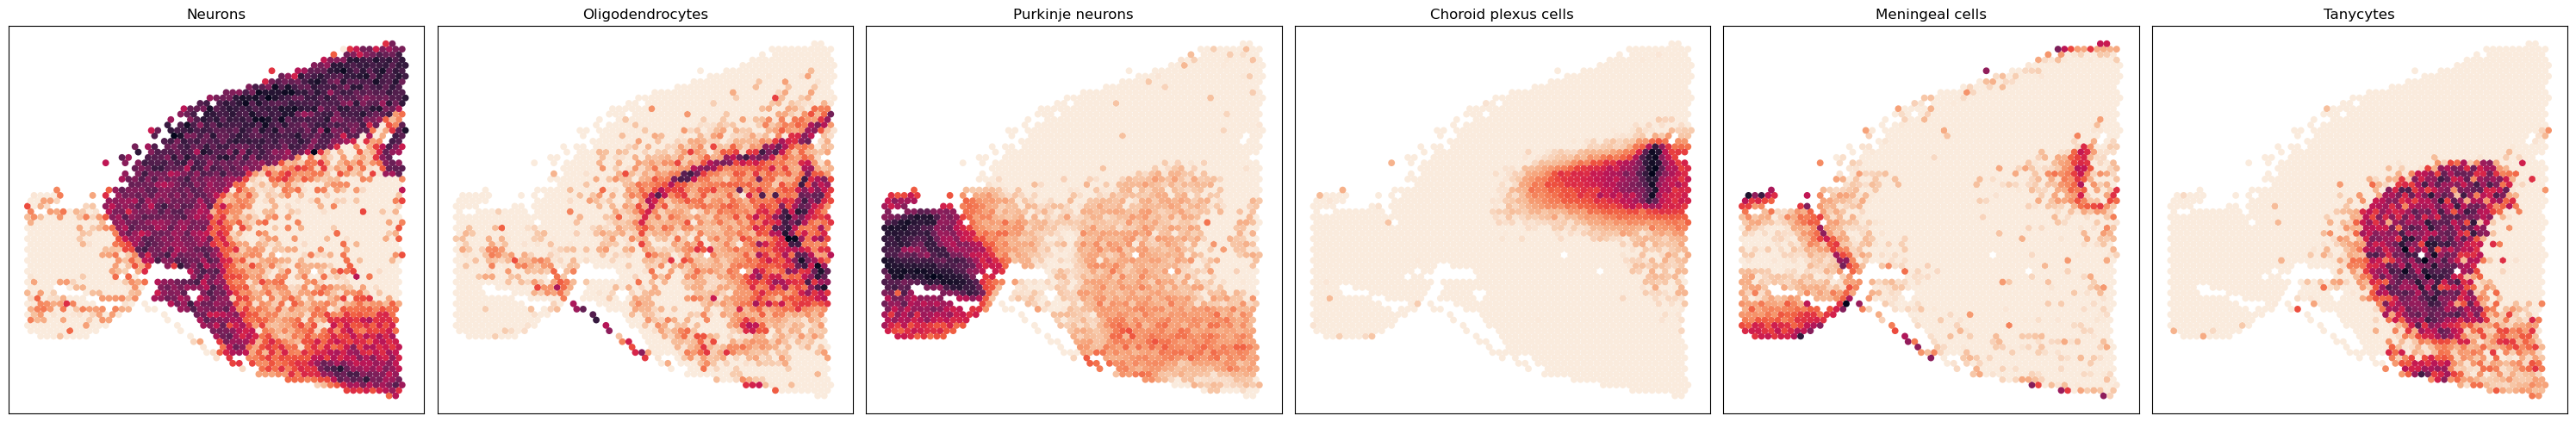

In [90]:
ncols = 6
nrows = ((len(relevant_factors) + ncols - 1) // ncols)
fig, axs = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(ncols * 5, nrows * 5), squeeze=False)
for i, rf in enumerate(relevant_factors):
    ax = sns.scatterplot(
        pd.concat([z_df, cov_df], axis=1), 
        # pd.concat([model.data["group_1"]["view_1"].to_df(), cov_df], axis=1), 
        x=0, 
        y=1, 
        hue=rf, 
        s=32, 
        palette=sns.color_palette("rocket_r", as_cmap=True),
        ax=axs[i // ncols, i % ncols],
        linewidth=0.0, 
        alpha = 1.0,
        rasterized=True,
        legend=False
    )
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set_title(rf)
    ax.set(xlabel=None)
    ax.set(ylabel=None)
    # ax.set_xticks(ticks=[], labels=[])
    # ax.set_yticks(ticks=[], labels=[])

plt.xticks(ticks=[], labels=[])
plt.yticks(ticks=[], labels=[])
fig.tight_layout()
plt.show()

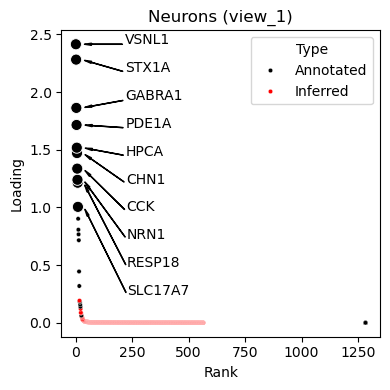

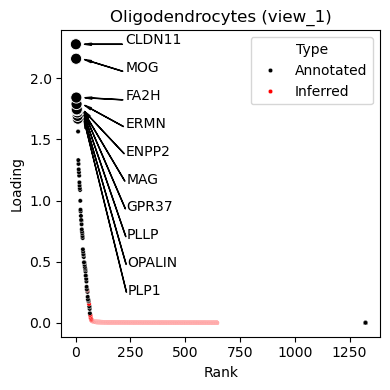

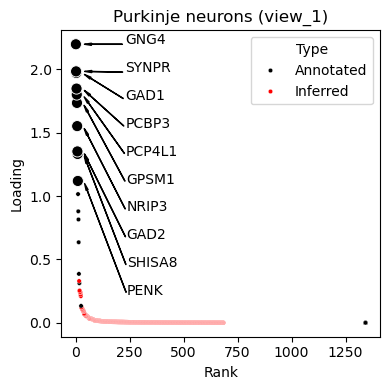

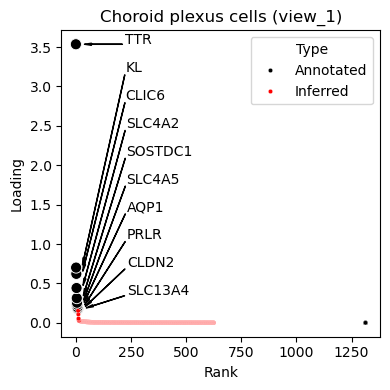

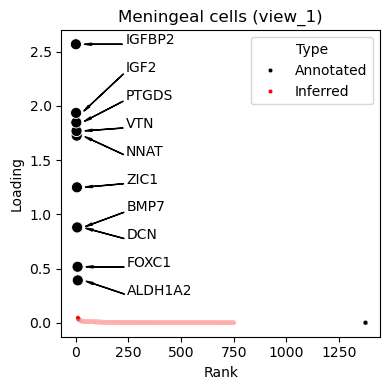

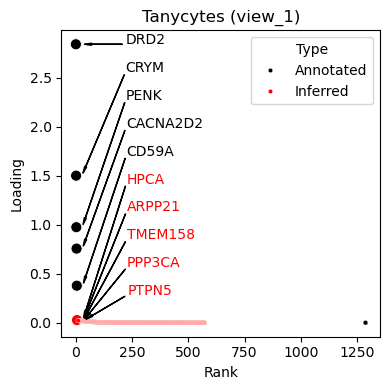

In [91]:
for rf in relevant_factors:
    plotting.plot_top_weights_muvi(model, rf, figsize=(4,4), top=10)
    plt.show()